# Example of Bibliography generation
(https://github.com/langchain-ai/open_deep_research)

In [1]:
SEARCH_API = "arxiv" # tavily

## Dependencies

In [2]:
# ! pip install -U -q open-deep-research
# ! pip install python-dotenv

### Load .env for all keys

In [3]:
%reload_ext dotenv
%dotenv

## Generate plan

0.0.10


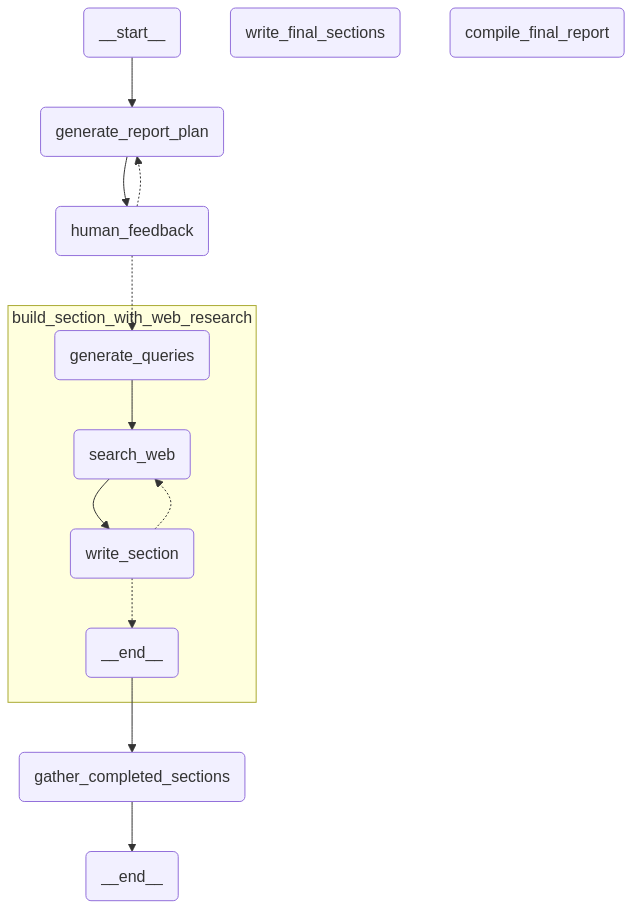

In [4]:
import open_deep_research   
print(open_deep_research.__version__) 

import os

from IPython.display import Image, display
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from open_deep_research.graph import builder

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Extract paper content

In [5]:
title = "LLM Evaluators Recognize and Favor Their OwnGenerations"
abstract = "Self-evaluation using large language models (LLMs) has proven valuable not onlyin benchmarking but also methods like reward modeling, constitutional AI, andself-refinement.  But new biases are introduced due to the same LLM acting asboth the evaluator and the evaluatee. One such bias is self-preference, where anLLM evaluator scores its own outputs higher than others’ while human annotatorsconsider them of equal quality. But do LLMs actually recognize their own outputswhen they give those texts higher scores, or is it just a coincidence? In this paper, weinvestigate if self-recognition capability contributes to self-preference. We discoverthat, out of the box, LLMs such as GPT-4 and Llama 2 have non-trivial accuracy atdistinguishing themselves from other LLMs and humans. By fine-tuning LLMs, wediscover a linear correlation between self-recognition capability and the strengthof self-preference bias; using controlled experiments, we show that the causalexplanation resists straightforward confounders. We discuss how self-recognitioncan interfere with unbiased evaluations and AI safety more generally."

In [6]:
# Input the paper as topic
import fitz  # PyMuPDF library is imported as 'fitz'
import sys

def extract_text_from_pdf_pymupdf(pdf_path):
    """
    Extracts text from all pages of a PDF file using PyMuPDF.

    Args:
        pdf_path (str): The file path to the PDF.

    Returns:
        str: The extracted text from the PDF, with pages separated by newlines.
             Returns None if the file cannot be processed.
    """
    try:
        doc = fitz.open(pdf_path)
    except FileNotFoundError:
        print(f"Error: File not found at '{pdf_path}'", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Error opening or processing PDF '{pdf_path}': {e}", file=sys.stderr)
        return None

    all_text = ""
    print(f"Processing '{pdf_path}'...")
    with doc:  # Ensures the document is closed properly
        for page_num, page in enumerate(doc):
            try:
                page_text = page.get_text("text") # Extract text as plain text
                if page_text: # Only add if text was found
                   all_text += f"--- Page {page_num + 1} ---\n"
                   all_text += page_text.strip() + "\n\n"
            except Exception as e:
                print(f"Error extracting text from page {page_num + 1}: {e}", file=sys.stderr)
                # Optionally continue to the next page or stop
                # continue

    if not all_text:
         print("Warning: No text could be extracted. The PDF might be image-based (scanned).", file=sys.stderr)

    print(f"Finished processing '{pdf_path}'.")
    return all_text.strip() # Remove trailing newlines

# --- Example Usage ---
pdf_file = "../../data/14702_LLM_Evaluators_Recognize.pdf"

full_paper_text = extract_text_from_pdf_pymupdf(pdf_file)

Processing '../../data/14702_LLM_Evaluators_Recognize.pdf'...
Finished processing '../../data/14702_LLM_Evaluators_Recognize.pdf'.


## Start generating 

In [7]:
import uuid 
from IPython.display import Markdown

REPORT_STRUCTURE = """Use this structure to create a bibliography on the user-provided paper:

1. Abstract
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section's title is the same as each user-provided paper's section title.
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the bibliography"""

thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": SEARCH_API,
                           "planner_provider": os.environ["MODEL_PROVIDER"],
                           "planner_model": os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
                           "writer_provider": os.environ["MODEL_PROVIDER"],
                           "writer_model": os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"], 
                           "report_structure": REPORT_STRUCTURE,
                           "max_search_depth": 1,}
                           } 

topic = "Bibliograp hy of the paper : " + title

# Run the graph until the interruption
async for event in graph.astream({"paper_content":full_paper_text,
                                  "title": title,
                                  "abstract": abstract,
                                  "topic": topic
                                  }, thread, stream_mode="updates"):

   if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))
   

Please provide feedback on the following bibliography plan. 
                        

Section: Abstract
Description: An overview of the paper's focus on self-recognition and self-preference in LLM evaluation, summarizing methodology and key findings.
Research needed: Yes


Section: Introduction
Description: This section covers the background, motivation, and the stated research questions regarding how LLM evaluators tend to favor their own outputs.
Research needed: Yes


Section: Definition and Measurement of Self-Preference and Self-Recognition
Description: Discusses the conceptual definitions and detailed experimental designs for measuring self-preference bias and self-recognition capability in LLMs.
Research needed: Yes


Section: Measuring Correlation between Self-Preference and Self-Recognition
Description: Focuses on the methodologies and fine-tuning experiments that link self-recognition capability to self-preference bias, including controlled experiments and statistical evaluations.
Research needed: Yes


Section: Related Work
Description: Summarizes previous literature on LLM self-evaluation, bias in model assessments, and methods in LLM detection and introspection, relating them to the user-provided paper’s contributions.
Research needed: Yes


Section: Limitations, Discussion, and Conclusion
Description: Covers the discussion of safety implications, limitations of the current study, future research directions, and a concluding synthesis of the insights gained.
Research needed: Yes


                        
Does the bibliography plan meet your needs?
Pass 'true' to approve the bibliography plan.
Or, provide feedback to regenerate the bibliography plan:

#### Pass feedback to update the report plan  (skipped for now)

In [8]:
# # Pass feedback to update the report plan  (skipped for now)
# feedback = "That's a good plan."
# async for event in graph.astream(Command(resume=feedback), thread, stream_mode="updates"):
#     if '__interrupt__' in event:
#         interrupt_value = event['__interrupt__'][0].value
#         display(Markdown(interrupt_value))

In [9]:
# Pass True to approve the report plan 
async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

{'human_feedback': None}


Error processing arXiv query 'LLM evaluators bias self-generated content favoring own outputs': module 'fitz' has no attribute 'fitz'
{'build_section_with_web_research': {'completed_sections': [Section(name='Introduction', description='This section covers the background, motivation, and the stated research questions regarding how LLM evaluators tend to favor their own outputs.', research=True, content='## Introduction\n\nLLM evaluators play a crucial role in assessing language generation quality. Recent studies reveal that both user interactions and automated evaluations may be subject to inherent biases. For instance, research indicates users often prefer responses where inaccuracies are unmarked, even when such responses are confidently delivered [1]. This suggests that evaluative systems might similarly be predisposed, potentially leading to an inadvertent favoring of self-generated outputs.\n\nMotivated by these observations, recent work has started to ex

In [10]:
final_state = graph.get_state(thread)
sources = final_state.values.get('sources')
sources

[Source(name='LLMs-as-Judges: A Comprehensive Survey on LLM-based Evaluation Methods', link='http://arxiv.org/abs/2412.05579v2'),
 Source(name='TencentLLMEval: A Hierarchical Evaluation of Real-World Capabilities for Human-Aligned LLMs', link='http://arxiv.org/abs/2311.05374v1'),
 Source(name='Fool Me, Fool Me: User Attitudes Toward LLM Falsehoods', link='http://arxiv.org/abs/2412.11625v1'),
 Source(name='Fairer Preferences Elicit Improved Human-Aligned Large Language Model Judgments', link='http://arxiv.org/abs/2406.11370v2'),
 Source(name='Self-Preference Bias in LLM-as-a-Judge', link='http://arxiv.org/abs/2410.21819v1'),
 Source(name='LLM Evaluators Recognize and Favor Their Own Generations', link='http://arxiv.org/abs/2404.13076v1'),
 Source(name='Do LLM Evaluators Prefer Themselves for a Reason?', link='http://arxiv.org/abs/2504.03846v1'),
 Source(name='Language Models Fail to Introspect About Their Knowledge of Language', link='http://arxiv.org/abs/2503.07513v2'),
 Source(name="I

In [14]:
# print the source better
for i, source in enumerate(sources):
    print(f"[{i+1}] {source.name}: {source.link}")

[1] LLMs-as-Judges: A Comprehensive Survey on LLM-based Evaluation Methods: http://arxiv.org/abs/2412.05579v2
[2] TencentLLMEval: A Hierarchical Evaluation of Real-World Capabilities for Human-Aligned LLMs: http://arxiv.org/abs/2311.05374v1
[3] Fool Me, Fool Me: User Attitudes Toward LLM Falsehoods: http://arxiv.org/abs/2412.11625v1
[4] Fairer Preferences Elicit Improved Human-Aligned Large Language Model Judgments: http://arxiv.org/abs/2406.11370v2
[5] Self-Preference Bias in LLM-as-a-Judge: http://arxiv.org/abs/2410.21819v1
[6] LLM Evaluators Recognize and Favor Their Own Generations: http://arxiv.org/abs/2404.13076v1
[7] Do LLM Evaluators Prefer Themselves for a Reason?: http://arxiv.org/abs/2504.03846v1
[8] Language Models Fail to Introspect About Their Knowledge of Language: http://arxiv.org/abs/2503.07513v2
[9] Introspective Planning: Aligning Robots' Uncertainty with Inherent Task Ambiguity: http://arxiv.org/abs/2402.06529v4
[10] Introspective Tips: Large Language Model for In-C

In [11]:
final_state = graph.get_state(thread)
report = final_state.values.get('report_sections_from_research')
Markdown(report)


============================================================
Section 1: Abstract
============================================================
Description:
An overview of the paper's focus on self-recognition and self-preference in LLM evaluation, summarizing methodology and key findings.
Requires Research: 
True

Content:
## Abstract

This paper examines a unique phenomenon where LLM evaluators exhibit self-recognition and self-preference when judging their own generations. Our work investigates how evaluation systems based on natural language responses may inherently favor outputs originating from the same model. The methodology combines error-based human annotation with meta-evaluation techniques to analyze the extent of evaluation biases. The findings indicate that self-generated outputs are consistently rated higher than independent ones, suggesting a systematic bias in automated evaluation protocols. This study builds on existing frameworks, such as the comprehensive survey of LLMs-as-judges [1] and hierarchical evaluation methods proposed in TencentLLMEval [2]. These sources provide essential insights into current evaluation methodologies and underscore challenges in ensuring objective assessments. Our results advocate for enhanced evaluation protocols that mitigate self-preference, thereby promoting fairness and improving reliability in LLM performance assessments across diverse tasks.

### Sources
[1] LLMs-as-Judges: A Comprehensive Survey on LLM-based Evaluation Methods: http://arxiv.org/abs/2412.05579v2  
[2] TencentLLMEval: A Hierarchical Evaluation of Real-World Capabilities for Human-Aligned LLMs: http://arxiv.org/abs/2311.05374v1


============================================================
Section 2: Introduction
============================================================
Description:
This section covers the background, motivation, and the stated research questions regarding how LLM evaluators tend to favor their own outputs.
Requires Research: 
True

Content:
## Introduction

LLM evaluators play a crucial role in assessing language generation quality. Recent studies reveal that both user interactions and automated evaluations may be subject to inherent biases. For instance, research indicates users often prefer responses where inaccuracies are unmarked, even when such responses are confidently delivered [1]. This suggests that evaluative systems might similarly be predisposed, potentially leading to an inadvertent favoring of self-generated outputs.

Motivated by these observations, recent work has started to explore how fairness in predictive preferences can improve the alignment of automated judgments with human expectations [2]. Such findings prompt questions regarding whether LLM evaluators recognize and favor their own generations, even when alternative responses might be more accurate. Addressing this research question is critical for improving the reliability and trustworthiness of LLM outputs. This investigation underscores the need for methods that mitigate evaluative bias to achieve a more balanced and fair assessment in language technology.

### Sources
[1] Fool Me, Fool Me: User Attitudes Toward LLM Falsehoods: http://arxiv.org/abs/2412.11625v1  
[2] Fairer Preferences Elicit Improved Human-Aligned Large Language Model Judgments: http://arxiv.org/abs/2406.11370v2


============================================================
Section 3: Definition and Measurement of Self-Preference and Self-Recognition
============================================================
Description:
Discusses the conceptual definitions and detailed experimental designs for measuring self-preference bias and self-recognition capability in LLMs.
Requires Research: 
True

Content:
## Definition and Measurement of Self-Preference and Self-Recognition

Self-preference bias refers to the tendency of a language model to favor its own outputs over those from other sources. Researchers define this bias by comparing evaluation scores assigned to self-generated texts versus externally produced texts. A key aspect of measuring the bias is the use of perplexity, where lower perplexity suggests greater text familiarity and leads to higher self-evaluation [1].

Experimental designs for assessing self-recognition involve controlled tests where models evaluate both self-generated and externally sourced responses. The novel quantitative metric examines differences in perplexity and assessment scores, thereby highlighting the role of self-recognition in driving self-preference. In addition, researchers have begun to investigate self-recognition by integrating diverse evaluation frameworks and employing both intrinsic and extrinsic metrics. This multifaceted approach aids in isolating the effect of familiarity and response style on bias, contributing to improved fairness and reliability in automated evaluations.

### Sources
[1] Self-Preference Bias in LLM-as-a-Judge: http://arxiv.org/abs/2410.21819v1


============================================================
Section 4: Measuring Correlation between Self-Preference and Self-Recognition
============================================================
Description:
Focuses on the methodologies and fine-tuning experiments that link self-recognition capability to self-preference bias, including controlled experiments and statistical evaluations.
Requires Research: 
True

Content:
## Measuring Correlation between Self-Preference and Self-Recognition

Research in this area focuses on evaluating how large language models (LLMs) develop self-preference biases through their inherent self-recognition abilities. Panickssery et al. [1] provide experimental evidence that LLMs like GPT-4 and Llama 2 can distinguish their own outputs from those generated by others. Their controlled fine-tuning experiments reveal a linear relationship between the self-recognition score and the strength of self-preference bias, using statistical analyses to rule out straightforward confounders.

Chen et al. [2] further examine self-preference by applying objective benchmarks in evaluating whether higher scores correspond to genuinely superior outputs or an inherent favoritism. Their methodologies employ verifiable tasks, such as mathematical reasoning and code generation, to differentiate beneficial self-recognition from harmful bias. Collectively, these studies emphasize the importance of controlled evaluation and fine-tuning experiments in understanding the causal link between a model’s self-recognition capability and its tendency to favor its own generations, contributing to improved reliability and AI safety.

### Sources
[1] LLM Evaluators Recognize and Favor Their Own Generations: http://arxiv.org/abs/2404.13076v1  
[2] Do LLM Evaluators Prefer Themselves for a Reason?: http://arxiv.org/abs/2504.03846v1


============================================================
Section 5: Related Work
============================================================
Description:
Summarizes previous literature on LLM self-evaluation, bias in model assessments, and methods in LLM detection and introspection, relating them to the user-provided paper’s contributions.
Requires Research: 
True

Content:
## Related Work
Previous research has explored whether large language models (LLMs) can reliably introspect their own internal states. For example, Song et al. [1] systematically investigated metalinguistic prompting to compare models’ self-reported probabilities with their internal string probability estimates, finding limited evidence for privileged self-access. In another vein, studies in robotics have leveraged introspective planning techniques to align LLMs’ uncertainty with task ambiguity, improving both safety and compliance [2]. Other works introduced introspective tips that allow LLMs to refine decision-making by reflecting on past interactions without parameter fine-tuning [3]. In parallel, bias evaluation in language models has attracted significant attention. Researchers have measured gender bias using both lexicon-based and novel model-based approaches, revealing instability in results dependent on metrics and data dependencies [4]. Additional tools, such as BiasAlert, have been proposed to detect social bias in open-text outputs, providing flexible alternatives to fixed-form assessments [5]. Furthermore, a new benchmark comparing multiple bias evaluation methods in generation tasks highlights inconsistencies between long-form and multiple-choice evaluations [6]. These works lay the groundwork for our study on LLM evaluators favoring their own generations.

### Sources
[1] Language Models Fail to Introspect About Their Knowledge of Language: http://arxiv.org/abs/2503.07513v2  
[2] Introspective Planning: Aligning Robots' Uncertainty with Inherent Task Ambiguity: http://arxiv.org/abs/2402.06529v4  
[3] Introspective Tips: Large Language Model for In-Context Decision Making: http://arxiv.org/abs/2305.11598v1  
[4] What is Your Favorite Gender, MLM? Gender Bias Evaluation in Multilingual Masked Language Models: http://arxiv.org/abs/2404.06621v1  
[5] BiasAlert: A Plug-and-play Tool for Social Bias Detection in LLMs: http://arxiv.org/abs/2407.10241v2  
[6] Social Bias Benchmark for Generation: A Comparison of Generation and QA-Based Evaluations: http://arxiv.org/abs/2503.06987v1


============================================================
Section 6: Limitations, Discussion, and Conclusion
============================================================
Description:
Covers the discussion of safety implications, limitations of the current study, future research directions, and a concluding synthesis of the insights gained.
Requires Research: 
True

Content:
## Limitations, Discussion, and Conclusion

This research section emphasizes several limitations and safety implications of using LLM evaluators. A key finding is the self-preference bias, where models assign higher scores to their own outputs, potentially misrepresenting actual quality and harming fair comparisons [1]. The study also notes inherent limitations in LLM performances, including reasoning flaws, memory issues, and calculation errors that restrict their reliability for critical applications [2].

Moreover, our discussion indicates that current evaluation frameworks may fall short in capturing complex real-world interactions. Incorporating human interaction evaluations can strengthen safety assessments and mitigate risks associated with biased self-recognition [3]. In conclusion, while LLM evaluators bring promising advances to automated assessments, their biases and operational limitations call for refined methods and integrated human oversight. Future research should focus on developing robust testing frameworks that blend technical improvements with comprehensive safety and governance strategies.

### Sources
[1] LLM Evaluators Recognize and Favor Their Own Generations: http://arxiv.org/abs/2404.13076v1  
[2] Responsible AI in Construction Safety: Systematic Evaluation of Large Language Models and Prompt Engineering: http://arxiv.org/abs/2411.08320v1  
[3] Beyond static AI evaluations: advancing human interaction evaluations for LLM harms and risks: http://arxiv.org/abs/2405.10632v5

